In [1]:
# Standard libraries
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
plt.rcParams['text.usetex'] = True
import random
import csv
import pandas as pd
import h5py
# Scikit learn libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# PyTorch libraries
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
# from torchvision.transforms import ToTensor, Normalize 
# Own scripts:
%load_ext autoreload
%autoreload 2
import physics
import data
import nnc2p
from collections import OrderedDict
# from nnc2p import NeuralNetwork # our own architecture
# Get dirs
import os
cwd = os.getcwd()# "Code" folder
master_dir = os.path.abspath(os.path.join(cwd, ".."))

# Introduction

See the NNC2Pv0 notebook, which was written in the first semester, for some background information. Here, we load the .py scripts which implement the methods etc written in that notebook in an organized manner.

# Own architectures

In [2]:
class Net(nn.Module):
    """
    Implements a simple feedforward neural network.
    """
    def __init__(self, nb_of_inputs: int = 3, nb_of_outputs: int = 1, h: list = [600, 200], 
                 reg: bool = False, activation_function = torch.nn.Sigmoid, output_bias=True) -> None:
        """
        Initialize the neural network class.
        """
        # Call the super constructor first
        super(Net, self).__init__()
        
        # For convenience, save the sizes of the hidden layers as fields as well
        self.h = h
        # Add visible layers as well: input is 3D and output is 1D
        self.h_augmented = [nb_of_inputs] + h + [nb_of_outputs]

        # Add field to specify whether or not we do regularization
        self.regularization = reg

        # Define the layers:
        for i in range(len(self.h_augmented)-1):
            # For the final layer, do/do not use a bias term (user choice)
            if i == len(self.h_augmented)-2:
                setattr(self, f"linear{i+1}", nn.Linear(self.h_augmented[i], self.h_augmented[i+1], bias=output_bias))
            else:
                setattr(self, f"linear{i+1}", nn.Linear(self.h_augmented[i], self.h_augmented[i+1]))
                setattr(self, f"activation{i+1}", activation_function())

    def forward(self, x):
        """
        Computes a forward step given the input x.
        :param x: Input for the neural network.
        :return: x: Output neural network
        """

        for i, module in enumerate(self.modules()):
            # The first module is the whole NNC2P object, continue
            if i == 0:
                continue
            x = module(x)

        return x

# Load in data

In [3]:
# Give the names of the input vars (features) and output vars (labels)
in_vars = ["D", "S", "tau"]
out_vars = ["p"]
# For normalization, use sklearn's StandardScaler -- give None for no normalization
scaler = StandardScaler()
# Read the sampled data as pandas dataframes
train_df = pd.read_csv(os.path.join(master_dir, "Data/ideal_gas_c2p_train_data.csv"))
test_df  = pd.read_csv(os.path.join(master_dir, "Data/ideal_gas_c2p_test_data.csv"))
# Convert to PyTorch Datasets as we defined them
train_dataset = data.CustomDataset(train_df, feature_names = in_vars, label_names = out_vars, normalization_function = None)  # scaler.fit_transform 
test_dataset  = data.CustomDataset(test_df, feature_names = in_vars, label_names = out_vars, normalization_function = None)  # scaler.transform
# Then create dataloaders, with batch size 32, from datasets
train_dataloader = DataLoader(train_dataset, batch_size=32)
test_dataloader  = DataLoader(test_dataset, batch_size=32)

In [4]:
train_df

rho       eps         v         p          D          S        tau
0      0.662984  0.084146  0.218802  0.037192   0.679448   0.173724   0.077335
1      8.565808  0.205945  0.657351  1.176059  11.366755  13.318537   7.718100
2      4.387112  1.598809  0.021593  4.676103   4.388135   0.347321   7.020631
3      5.337054  0.530803  0.351307  1.888615   5.700396   4.031171   3.885760
4      1.133895  0.786717  0.079475  0.594703   1.137493   0.209600   0.905115
...         ...       ...       ...       ...        ...        ...        ...
79995  8.101834  0.428605  0.616897  2.314990  10.294002  13.832316   9.813427
79996  7.841014  1.125480  0.209087  5.883268   8.018242   4.930289   9.678536
79997  4.628822  0.194190  0.237759  0.599248   4.765476   1.544018   1.129323
79998  9.913117  1.152242  0.477216  7.614874  11.280468  17.889657  18.592193
79999  9.717025  0.001552  0.163383  0.010052   9.849373   1.635352   0.149919

[80000 rows x 7 columns]

# Training a network

In [5]:
model = Net(h=[504, 127], output_bias=True)
device = "cpu"
model

Net(
  (linear1): Linear(in_features=3, out_features=504, bias=True)
  (activation1): Sigmoid()
  (linear2): Linear(in_features=504, out_features=127, bias=True)
  (activation2): Sigmoid()
  (linear3): Linear(in_features=127, out_features=1, bias=True)
)

In [6]:
nnc2p.count_parameters(model)

66279

## Load network trained before

In [7]:
model_dict = torch.load(os.path.join(master_dir, "Models/finetuned_most_pruned.pth"))
# Check whether the model we defined has output bias or not. No bias, then pop this param from dict
if model.linear3.bias == None:
    model_dict.pop('linear3.bias', None)
    print(model_dict.keys())
# Load the model    
model.load_state_dict(model_dict)

<All keys matched successfully>

Getting ready to train:

In [8]:
# Save hyperparameters, loss function and optimizer for training (see paper for details)
learning_rate = 1e-2
batch_size = 32
# NEW - trying out some physics-inspired loss!
# loss_fn = nnc2p.c2p_loss
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Define a trainer object and train it

In [9]:
# trainer = nnc2p.Trainer(model, learning_rate, train_dataloader=train_dataloader, test_dataloader=test_dataloader)

In [10]:
# trainer.train(number_of_epochs=1000)

Save the neural network/state dict:

In [11]:
# torch.save(new, 'Models/NNC2P_new_loss.pth')

In [12]:
# torch.save(model.state_dict(), os.path.join(master_dir, 'Models/NNC2P_10_10.pth'))

# Check performance

For the final plots: need the delta_N, the relative error on rho values!

In [50]:
input_data = np.transpose(np.array([train_df["D"], train_df["S"], train_df["tau"]]))
d, s, t = train_df["D"].values, train_df["S"].values, train_df["tau"].values
true_rho = np.array([train_df["rho"]])
# Predictions
with torch.no_grad():
    input_data = torch.from_numpy(input_data).float()
    pred = model(input_data)
    pred = pred.numpy()
# Get rho
pred_rho = []
for i in range(len(pred)):
    _, _, _, value = physics.get_prims(d[i], s[i], t[i], pred[i])
    pred_rho.append(value)
pred_rho = np.array(pred_rho).flatten()

Some NaNs occured, remove them from both predictions and true values

In [51]:
mask = np.isnan(pred_rho)
pred_rho = pred_rho[~mask]
true_rho = true_rho.flatten()[~mask]

In [52]:
# Difference
delta_N = np.sum(abs(pred_rho - true_rho))/np.sum(abs(true_rho))
print(delta_N)

4.54434445558837e-06


# NEW (experimental) - neural net assist

In [10]:
# Read the sampled data as pandas dataframes
train_df = pd.read_csv(os.path.join(master_dir, "Data/ideal_gas_c2p_train_data.csv"))
test_df  = pd.read_csv(os.path.join(master_dir, "Data/ideal_gas_c2p_test_data.csv"))

In [11]:
train_df

rho       eps         v         p          D          S        tau
0      0.662984  0.084146  0.218802  0.037192   0.679448   0.173724   0.077335
1      8.565808  0.205945  0.657351  1.176059  11.366755  13.318537   7.718100
2      4.387112  1.598809  0.021593  4.676103   4.388135   0.347321   7.020631
3      5.337054  0.530803  0.351307  1.888615   5.700396   4.031171   3.885760
4      1.133895  0.786717  0.079475  0.594703   1.137493   0.209600   0.905115
...         ...       ...       ...       ...        ...        ...        ...
79995  8.101834  0.428605  0.616897  2.314990  10.294002  13.832316   9.813427
79996  7.841014  1.125480  0.209087  5.883268   8.018242   4.930289   9.678536
79997  4.628822  0.194190  0.237759  0.599248   4.765476   1.544018   1.129323
79998  9.913117  1.152242  0.477216  7.614874  11.280468  17.889657  18.592193
79999  9.717025  0.001552  0.163383  0.010052   9.849373   1.635352   0.149919

[80000 rows x 7 columns]

Define a new column: we are going to train the output on that

In [12]:
for df in [train_df, test_df]:
    W = np.sqrt(1/(1-df["v"]**2))
    h = 1 + df["eps"] + (df["p"]/df["rho"])
    
    df["mu"] = 1/(W*h)

In [13]:
train_df

rho       eps         v         p          D          S  \
0      0.662984  0.084146  0.218802  0.037192   0.679448   0.173724   
1      8.565808  0.205945  0.657351  1.176059  11.366755  13.318537   
2      4.387112  1.598809  0.021593  4.676103   4.388135   0.347321   
3      5.337054  0.530803  0.351307  1.888615   5.700396   4.031171   
4      1.133895  0.786717  0.079475  0.594703   1.137493   0.209600   
...         ...       ...       ...       ...        ...        ...   
79995  8.101834  0.428605  0.616897  2.314990  10.294002  13.832316   
79996  7.841014  1.125480  0.209087  5.883268   8.018242   4.930289   
79997  4.628822  0.194190  0.237759  0.599248   4.765476   1.544018   
79998  9.913117  1.152242  0.477216  7.614874  11.280468  17.889657   
79999  9.717025  0.001552  0.163383  0.010052   9.849373   1.635352   

             tau        mu  
0       0.077335  0.855755  
1       7.718100  0.561019  
2       7.020631  0.272811  
3       3.885760  0.496776  
4       0.905115  0.431308  
...          ...       ...  
79995   9.813427  0.459094  
79996   9.678536  0.340044  
79997   1.129323  0.733822  
79998  18.592193  0.300912  
79999   0.149919  0.984018  

[80000 rows x 8 columns]

In [14]:
# Give the names of the input vars (features) and output vars (labels)
in_vars = ["D", "S", "tau"]
out_vars = ["mu"]
# For normalization, use sklearn's StandardScaler -- give None for no normalization
scaler = StandardScaler()
# Convert to PyTorch Datasets as we defined them
train_dataset = data.CustomDataset(train_df, feature_names = in_vars, label_names = out_vars, normalization_function = None)  # scaler.fit_transform 
test_dataset  = data.CustomDataset(test_df, feature_names = in_vars, label_names = out_vars, normalization_function = None)  # scaler.transform
# Then create dataloaders, with batch size 32, from datasets
train_dataloader = DataLoader(train_dataset, batch_size=32)
test_dataloader  = DataLoader(test_dataset, batch_size=32)

# Training a network

In [24]:
model = Net(h=[10, 10], output_bias=False)
device = "cpu"
model

Net(
  (linear1): Linear(in_features=3, out_features=10, bias=True)
  (activation1): Sigmoid()
  (linear2): Linear(in_features=10, out_features=10, bias=True)
  (activation2): Sigmoid()
  (linear3): Linear(in_features=10, out_features=1, bias=False)
)

In [25]:
nnc2p.count_parameters(model)

160

Define a trainer object and train it

In [26]:
trainer = nnc2p.Trainer(model, 1e-2, train_dataloader=train_dataloader, test_dataloader=test_dataloader)

In [27]:
trainer.train(number_of_epochs=1000)

Training the model for 1000 epochs.

 Epoch 0 
 --------------
Train loss: 3.24E-04
Test  loss: 2.58E-04

 Epoch 1 
 --------------
Train loss: 2.05E-04
Test  loss: 1.62E-04

 Epoch 2 
 --------------
Train loss: 1.86E-04
Test  loss: 1.52E-04

 Epoch 3 
 --------------
Train loss: 1.87E-04
Test  loss: 1.56E-04

 Epoch 4 
 --------------
Train loss: 1.92E-04
Test  loss: 1.62E-04

 Epoch 5 
 --------------
Train loss: 1.79E-04
Test  loss: 1.49E-04

 Epoch 6 
 --------------
Train loss: 1.48E-04
Test  loss: 1.22E-04

 Epoch 7 
 --------------
Train loss: 1.27E-04
Test  loss: 1.03E-04

 Epoch 8 
 --------------
Train loss: 1.10E-04
Test  loss: 8.76E-05

 Epoch 9 
 --------------
Train loss: 9.92E-05
Test  loss: 7.79E-05

 Epoch 10 
 --------------
Train loss: 9.28E-05
Test  loss: 7.27E-05

 Epoch 11 
 --------------
Train loss: 8.93E-05
Test  loss: 7.03E-05

 Epoch 12 
 --------------
Train loss: 8.73E-05
Test  loss: 6.93E-05

 Epoch 13 
 --------------
Train loss: 8.59E-05
Test  loss: 6.8

Train loss: 2.94E-05
Test  loss: 2.58E-05

 Epoch 117 
 --------------
Train loss: 2.93E-05
Test  loss: 2.58E-05

 Epoch 118 
 --------------
Train loss: 2.92E-05
Test  loss: 2.57E-05

 Epoch 119 
 --------------
Train loss: 2.91E-05
Test  loss: 2.57E-05

 Epoch 120 
 --------------
Train loss: 2.90E-05
Test  loss: 2.56E-05

 Epoch 121 
 --------------
Train loss: 2.89E-05
Test  loss: 2.55E-05

 Epoch 122 
 --------------
Train loss: 2.88E-05
Test  loss: 2.55E-05

 Epoch 123 
 --------------
Train loss: 2.88E-05
Test  loss: 2.54E-05

 Epoch 124 
 --------------
Train loss: 2.87E-05
Test  loss: 2.53E-05

 Epoch 125 
 --------------
Train loss: 2.86E-05
Test  loss: 2.53E-05

 Epoch 126 
 --------------
Train loss: 2.85E-05
Test  loss: 2.52E-05

 Epoch 127 
 --------------
Train loss: 2.84E-05
Test  loss: 2.52E-05

 Epoch 128 
 --------------
Train loss: 2.83E-05
Test  loss: 2.51E-05

 Epoch 129 
 --------------
Train loss: 2.83E-05
Test  loss: 2.51E-05

 Epoch 130 
 --------------
Train 

Train loss: 2.31E-05
Test  loss: 2.31E-05

 Epoch 233 
 --------------
Train loss: 2.30E-05
Test  loss: 2.31E-05

 Epoch 234 
 --------------
Train loss: 2.30E-05
Test  loss: 2.31E-05

 Epoch 235 
 --------------
Train loss: 2.29E-05
Test  loss: 2.31E-05

 Epoch 236 
 --------------
Train loss: 2.28E-05
Test  loss: 2.30E-05

 Epoch 237 
 --------------
Train loss: 2.27E-05
Test  loss: 2.30E-05

 Epoch 238 
 --------------
Train loss: 2.27E-05
Test  loss: 2.29E-05

 Epoch 239 
 --------------
Train loss: 2.26E-05
Test  loss: 2.28E-05

 Epoch 240 
 --------------
Train loss: 2.24E-05
Test  loss: 2.27E-05

 Epoch 241 
 --------------
Train loss: 2.23E-05
Test  loss: 2.26E-05

 Epoch 242 
 --------------
Train loss: 2.22E-05
Test  loss: 2.25E-05

 Epoch 243 
 --------------
Train loss: 2.21E-05
Test  loss: 2.24E-05

 Epoch 244 
 --------------
Train loss: 2.20E-05
Test  loss: 2.23E-05

 Epoch 245 
 --------------
Train loss: 2.18E-05
Test  loss: 2.22E-05

 Epoch 246 
 --------------
Train 

Train loss: 1.32E-05
Test  loss: 1.47E-05

 Epoch 348 
 --------------
Train loss: 1.32E-05
Test  loss: 1.47E-05

 Epoch 349 
 --------------
Train loss: 1.32E-05
Test  loss: 1.47E-05

 Epoch 350 
 --------------
Train loss: 1.31E-05
Test  loss: 1.47E-05

 Epoch 351 
 --------------
Train loss: 1.31E-05
Test  loss: 1.47E-05

 Epoch 352 
 --------------
Train loss: 1.31E-05
Test  loss: 1.47E-05

 Epoch 353 
 --------------
Train loss: 1.31E-05
Test  loss: 1.47E-05

 Epoch 354 
 --------------
Train loss: 1.31E-05
Test  loss: 1.47E-05

 Epoch 355 
 --------------
Train loss: 1.31E-05
Test  loss: 1.47E-05

 Epoch 356 
 --------------
Train loss: 1.31E-05
Test  loss: 1.47E-05

 Epoch 357 
 --------------
Train loss: 1.31E-05
Test  loss: 1.47E-05

 Epoch 358 
 --------------
Train loss: 1.31E-05
Test  loss: 1.47E-05

 Epoch 359 
 --------------
Train loss: 1.31E-05
Test  loss: 1.47E-05

 Epoch 360 
 --------------
Train loss: 1.30E-05
Test  loss: 1.47E-05

 Epoch 361 
 --------------
Train 

Train loss: 1.22E-05
Test  loss: 1.46E-05

 Epoch 464 
 --------------
Train loss: 1.22E-05
Test  loss: 1.46E-05

 Epoch 465 
 --------------
Train loss: 1.22E-05
Test  loss: 1.46E-05

 Epoch 466 
 --------------
Train loss: 1.22E-05
Test  loss: 1.46E-05

 Epoch 467 
 --------------
Train loss: 1.22E-05
Test  loss: 1.46E-05

 Epoch 468 
 --------------
Train loss: 1.22E-05
Test  loss: 1.46E-05

 Epoch 469 
 --------------
Train loss: 1.22E-05
Test  loss: 1.46E-05

 Epoch 470 
 --------------
Train loss: 1.22E-05
Test  loss: 1.46E-05

 Epoch 471 
 --------------
Train loss: 1.22E-05
Test  loss: 1.46E-05

 Epoch 472 
 --------------
Train loss: 1.22E-05
Test  loss: 1.46E-05

 Epoch 473 
 --------------
Train loss: 1.22E-05
Test  loss: 1.46E-05

 Epoch 474 
 --------------
Train loss: 1.22E-05
Test  loss: 1.46E-05

 Epoch 475 
 --------------
Train loss: 1.22E-05
Test  loss: 1.46E-05

 Epoch 476 
 --------------
Train loss: 1.22E-05
Test  loss: 1.46E-05

 Epoch 477 
 --------------
Train 

Train loss: 1.09E-05
Test  loss: 1.27E-05

 Epoch 579 
 --------------
Train loss: 1.08E-05
Test  loss: 1.27E-05

 Epoch 580 
 --------------
Train loss: 1.08E-05
Test  loss: 1.27E-05

 Epoch 581 
 --------------
Train loss: 1.08E-05
Test  loss: 1.27E-05

 Epoch 582 
 --------------
Train loss: 1.08E-05
Test  loss: 1.26E-05

 Epoch 583 
 --------------
Train loss: 1.07E-05
Test  loss: 1.26E-05

 Epoch 584 
 --------------
Train loss: 1.07E-05
Test  loss: 1.26E-05

 Epoch 585 
 --------------
Train loss: 1.07E-05
Test  loss: 1.26E-05

 Epoch 586 
 --------------
Train loss: 1.07E-05
Test  loss: 1.26E-05

 Epoch 587 
 --------------
Train loss: 1.06E-05
Test  loss: 1.25E-05

 Epoch 588 
 --------------
Train loss: 1.06E-05
Test  loss: 1.25E-05

 Epoch 589 
 --------------
Train loss: 1.06E-05
Test  loss: 1.25E-05

 Epoch 590 
 --------------
Train loss: 1.06E-05
Test  loss: 1.25E-05

 Epoch 591 
 --------------
Train loss: 1.06E-05
Test  loss: 1.25E-05

 Epoch 592 
 --------------
Train 

KeyboardInterrupt: 

Save the neural network/state dict:

In [28]:
torch.save(model.state_dict(), os.path.join(master_dir, 'Models/NNassist_10_10.pth'))

# Analyzing neural networks

## Plot the losses during training

In [1]:
# Plot it
plt.figure()
lw = 1
ms = 2
plt.plot(trainer.train_losses, 'o--', color = 'red', label = 'Train set', lw = lw, ms = ms)
plt.plot(trainer.test_losses, 'o--', color = 'blue', label = "Test set", lw = lw, ms = ms)
plt.legend()
plt.grid()
plt.xlabel("Epoch")
xt_step = 50
xt = [i*xt_step for i in range(len(train_losses)//xt_step+2)]
plt.xticks(xt)
plt.ylabel(r'$L$')
plt.axhline(0, color = 'black', alpha = 0.7)
plt.title("Loss")
# Plot when we adapted learning rate
for t in adaptation_indices:
    plt.axvline(t+200, linestyle = "--", color = 'black', alpha = 0.5, lw = 1)
plt.yscale('log')
# plt.ylim(10**(-9))
# plt.savefig("Plots/test.pdf", bbox_inches = 'tight')
plt.show()

## Estimate the performance of the network

__New version:__ TODO

__Old version:__

In [13]:
# Get features and labels
test_features = nnc2p.TEST_DATA.features
test_labels = nnc2p.TEST_DATA.labels
test_features[:4]

tensor([[10.2041, 12.0266, 22.1313],
        [ 7.0046, 22.3374, 21.0772],
        [ 9.5747, 10.5188, 10.0152],
        [ 0.7725,  1.8519,  1.8100]])

In [14]:
# Get predictions
with torch.no_grad():
    p_hat= np.array([])
    for input_values in test_features:
        prediction = model(input_values)
        p_hat = np.append(p_hat, prediction[0].item())

In [15]:
# Get labels as np arrays
p = np.array([])
for value in test_labels:
    p = np.append(p, value[0].item())

In [16]:
# Get the errors:
delta_p_L1 = nnc2p.l1_norm(p_hat, p)
delta_p_Linfty = nnc2p.linfty_norm(p_hat, p)

In [17]:
print("Errors for p: %e  with L1 and %e with Linfty" % (delta_p_L1, delta_p_Linfty) )

Errors for p: 2.608495e-04  with L1 and 6.769918e-03 with Linfty


# Physics inspired neural networks

Here, we try to incorporate some of the physics into the knowledge of the network, more specifically in the training.

## C2C chain (C2P $\circ$ P2C )

In [18]:
model = model.float()

In [19]:
test_cons  = nnc2p.TEST_DATA.features[0]
test_press = nnc2p.TEST_DATA.labels[0]
print(test_cons)
print(test_press.item())

tensor([10.2041, 12.0266, 22.1313])
12.866164207458496


In [20]:
# Get og prim values
og_rho = test_df.loc[0].rho
og_eps = test_df.loc[0].eps
print(og_rho)
print(og_eps)

# Testing C2C single example
test_cons = nnc2p.TEST_DATA.features[0]
D_test, S_test, tau_test = test_cons[0].item(), test_cons[1].item(), test_cons[2].item()
print(test_cons)
with torch.no_grad():
    press = model(test_cons.float()).item()
print("p:   ", press)
v_value, W_value, eps_value, rho_value = physics.get_prims(D_test, S_test, tau_test, p=press)
print(f"rho: {rho_value}, original: {og_rho}, difference: {abs(rho_value - og_rho)}")
print(f"eps: {eps_value}, original: {og_eps}, difference: {abs(eps_value - og_eps)}")
d, s, t = physics.p2c(rho_value, eps_value, v_value, press)
print(f"D_test: {D_test}, after C2C: {d}: difference {abs(D_test - d)}")
print(f"S_test: {S_test}, after C2C: {s}: difference {abs(S_test - s)}")

9.83632270803203
1.962038705851822
tensor([10.2041, 12.0266, 22.1313])
p:    12.866581916809082
rho: 9.836329619796622, original: 9.83632270803203, difference: 6.911764591777114e-06
eps: 1.9620395587685673, original: 1.962038705851822, difference: 8.529167452309139e-07
D_test: 10.204131126403809, after C2C: 10.204131126403812: difference 3.552713678800501e-15
S_test: 12.02658462524414, after C2C: 12.026584625244146: difference 5.329070518200751e-15


In [21]:
test_cons = nnc2p.TEST_DATA.features[0]
D_test, S_test, tau_test = test_cons[0].item(), test_cons[1].item(), test_cons[2].item()
D_new, S_new, tau_new = physics.c2c(D_test, S_test, tau_test, model, nb_repetitions=1)
# print(D_test, S_test, tau_test)
# print(D_new, S_new, tau_new)
print(abs(np.array([D_test, S_test, tau_test]) - np.array([D_new, S_new, tau_new])))

[3.55271368e-15 5.32907052e-15 1.77635684e-14]


Loop over a whole datasets:

In [22]:
l1_error, l2_error = physics.c2c_dataset(nnc2p.TEST_DATA, model)
mse_error = np.mean(l2_error)

D:\Coding\master-thesis-AI\Code\physics.py:166: RuntimeWarning: invalid value encountered in sqrt
  W_value = 1 / np.sqrt(1 - v ** 2)


In [24]:
# # Loop
# mse_errors = []
# reps = np.arange(1, 21, 2)
# nb_repetitions = 1
# l1_error, l2_error = physics.c2c_dataset(nnc2p.TEST_DATA, model, nb_repetitions=nb_repetitions)
# mse_error = np.mean(l2_error)
# mse_errors.append(mse_error)

In [25]:
# plt.plot(reps, mse_errors, '-o', color='red')
# plt.xlabel("Number of C2C repetitions")
# plt.ylabel("MSE on 10 000 test datapoints")
# plt.title("Robustness of neural net C2P")
# plt.grid()
# plt.show()

## P2P chain

__Single velocity value:__

In [61]:
import seaborn as sn

In [84]:
# plot hyperparameters
fs = 12

plt.figure(figsize=(7,3))
v = 0.35
n = 200
n_rho = n
n_eps = n
rho_min, rho_max = 0.05, 10
eps_min, eps_max = 0.01, 2

# Get everything ready for the plot
rho_vals = np.linspace(rho_min, rho_max, n_rho)
eps_vals = np.linspace(eps_min, eps_max, n_eps)
delta_vals = np.zeros((n_eps, n_rho))

delta_vals = np.zeros((n_eps, n_rho))
# Get the matrix to plot later on
for a, eps in enumerate(eps_vals):
    for b, rho in enumerate(rho_vals):
        # Get exact pressure
        p_exact = physics.ideal_eos(rho, eps)
        # Get the pressure
        p_pred = physics.p2p(rho, eps, v, model)
        delta_vals[a][b] = abs(p_exact - p_pred)

# df_for_plot = pd.DataFrame(delta_vals, index = eps_vals, columns = rho_vals)

# Then plot it
# fs=20
fig = plt.figure(figsize=(15,2))
plt.imshow(delta_vals, origin="lower", norm=LogNorm(vmin=1e-9, vmax=1e0))
# Define your desired tick positions and corresponding labels
tick_positions = np.array([0, 100, 200])
# eps_labels = [r"$0.2$", r"$0.8$", r"$1.2$", r"$1.6$", r"$2.0$"]
# rho_labels = [r"$2.0$", r"$4.0$", r"$6.0$", r"$8.0$", r"$10.0$"]
eps_labels = [r"$0.0$", r"$1.0$", r"$2.0$"]
rho_labels = [r"$0.0$", r"$5.0$", r"$10.0$"]
plt.xlabel(r"$\rho$", fontsize=fs)
plt.xticks(tick_positions, labels=rho_labels, fontsize=12)
plt.yticks(tick_positions, labels=eps_labels, fontsize=12)
plt.ylabel(r"$\varepsilon$", fontsize=fs)
plt.title(r"$v = 0.35$", fontsize=fs-3)
cbar = plt.colorbar()
cbar.set_label(label=r"$\Delta p$", fontsize=fs)
plt.savefig(os.path.join(master_dir, "Plots/Final/NNC2P_ideal_gas_recovery_delta_p.pdf"), bbox_inches='tight')
plt.show()

<Figure size 700x300 with 0 Axes>

Curious, so small test:

In [87]:
small = 1e-5
print(physics.p2c(small, small, small, physics.ideal_eos(small, small)))

(1.0000000000500001e-05, 1.0000166667666686e-10, 1.0000050001732056e-10)


Investigate several values for velocity:

__TODO__ fix the plot: the labels and the tick ranges. Adjust the colorbar range properly. Note: for 200 points each direction, takes quite long to plot (1m30s). 

TypeError: 'AxesSubplot' object is not iterable

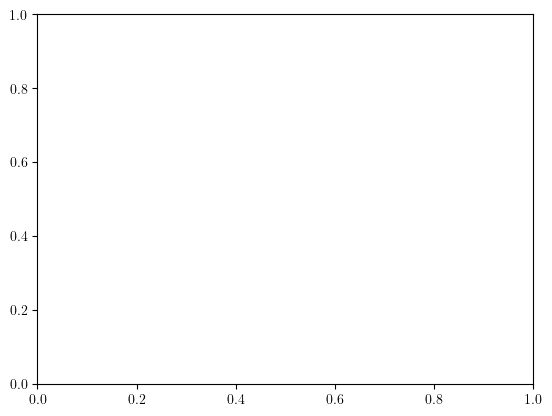

In [29]:
# v_list = [0, 0.35, 0.7]
# fig, axs = plt.subplots(1, len(v_list), sharey=True)

# for i, ax in enumerate(axs):
#     # Initialize v and zero the matrix
#     v = v_list[i]
#     delta_vals = np.zeros((n_eps, n_rho))
#     # Get the matrix to plot later on
#     for a, eps in enumerate(eps_vals):
#         for b, rho in enumerate(rho_vals):
#             # Get exact pressure
#             p_exact = physics.ideal_eos(rho, eps)
#             # Get the pressure
#             p_pred = physics.p2p(rho, eps, v, model)
#             delta_vals[a][b] = abs(p_exact - p_pred)
#     # Then plot it
#     im = ax.imshow(delta_vals, origin="lower", norm=LogNorm(vmin=1e-9, vmax=1e0))
#     ax.set_xlabel("rho")
#     ax.set_ylabel("eps")
#     ax.set_title(f"v = {v}")
# fig.colorbar(im, ax=axs)
# plt.savefig(os.path.join(master_dir, "Plots/recovery_delta_p_plot.pdf"), bbox_inches='tight')
# plt.show()

Investigate several loops

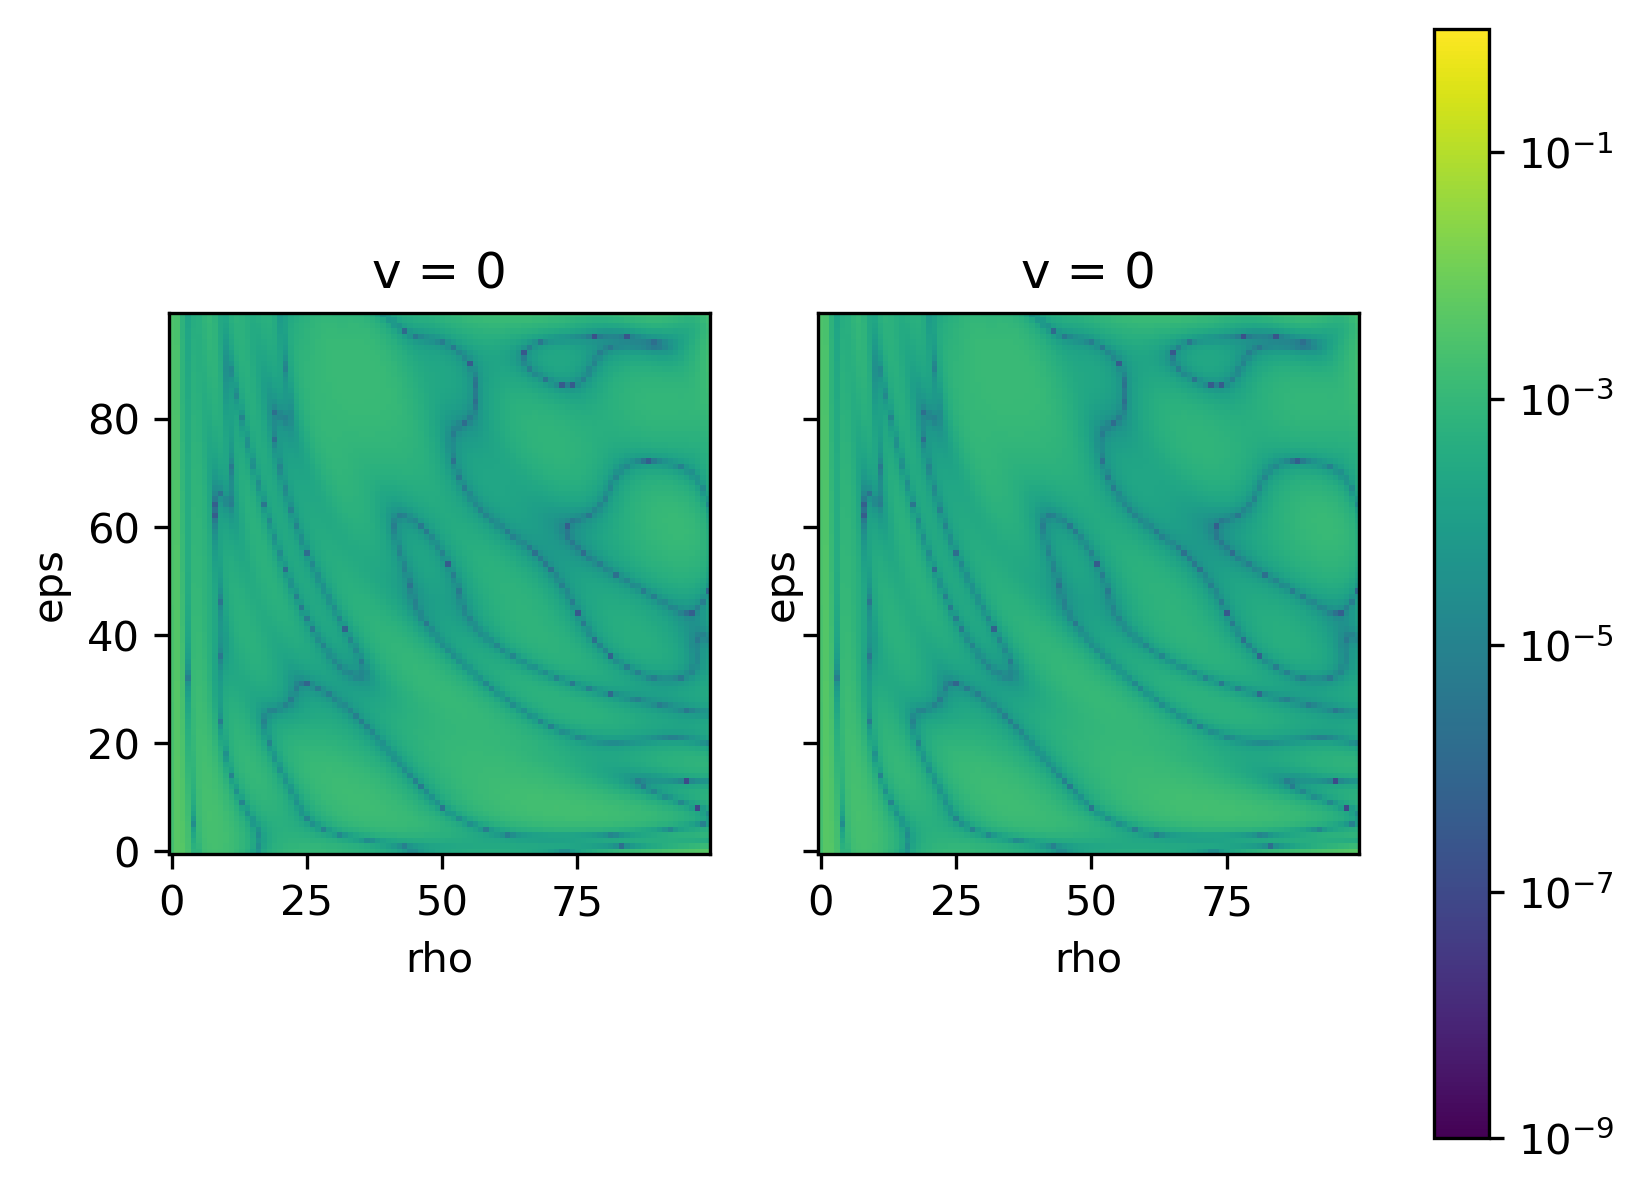

In [204]:
# v = 0
# nb_repetitions_list = [1, 10]

# fig, axs = plt.subplots(1, len(nb_repetitions_list), sharey=True)

# for i, ax in enumerate(axs):
#     # Initialize v and zero the matrix
#     nb_repetitions = nb_repetitions_list[i]
#     delta_vals = np.zeros((n_eps, n_rho))
#     # Get the matrix to plot later on
#     for a, eps in enumerate(eps_vals):
#         for b, rho in enumerate(rho_vals):
#             # Get exact pressure
#             p_exact = physics.ideal_eos(rho, eps)
#             # Get the pressure
#             p_pred = physics.p2p(rho, eps, v, model, nb_repetitions=nb_repetitions)
#             delta_vals[a][b] = abs(p_exact - p_pred)
#     # Then plot it
#     im = ax.imshow(delta_vals, origin="lower", norm=LogNorm(vmin=1e-9, vmax=1e0))
#     ax.set_xlabel("rho")
#     ax.set_ylabel("eps")
#     ax.set_title(f"v = {v}")
# fig.colorbar(im, ax=axs)
# plt.show()

# Performance on untrained cases:

__NOTE__ This is a very old piece of code. The goal here was to see how the network performs if we give it examples out of the ranges of its training data. 

Here, we check the performance whenever we use the model on values on which it wasn't trained. Is there a large error compared to the case of seen data?

## When only one parameter gets outside of its range

In [104]:
# We are going to save the performance according to the ranges specified:
# this dict is filled with the errors we found above
errors_dict = {
    "rho max": [rho_max],
    "eps max":[eps_max],
    "v max":[v_max],
    "L1":[delta_p_L1],
    "Linfty":[delta_p_Linfty]}

# Get the parameters we are going to test

# This is how we are going to increment the upper bound each run
delta_rho = 0.01
delta_eps = 0.01
delta_v     = 0.001

number_of_runs = 100

# Construct the parameters
rho_list = [[rho_max + i*delta_rho, eps_max, v_max] for i in range(1, number_of_runs)]
eps_list = [[rho_max, eps_max + i*delta_eps, v_max] for i in range(1, number_of_runs)]
v_list = [[rho_max, eps_max, v_max + i*delta_v] for i in range(1, number_of_runs)]

parameters_list = rho_list + eps_list + v_list 

In [105]:
number_of_datapoints = 10000

p = []
phat = []

with torch.no_grad():
    # Iterate over all parameter bounds
    for [rho_bound, eps_bound, v_bound] in parameters_list:
        # Save current value:
        errors_dict["rho max"].append(rho_bound)
        errors_dict["eps max"].append(eps_bound)
        errors_dict["v max"].append(v_bound)
        
        # Now get 10 000 new cases and predictions
        for i in range(number_of_datapoints):
            
            # Sample randomly from the new range
            rho = random.uniform(rho_min, rho_bound)
            eps = random.uniform(eps_min, eps_bound)
            v     = random.uniform(v_min,           v_bound)
            
            # Get true value
            p.append(eos(rho, eps))

            # Get the prediction
            
            # Compute features (D, S, tau)
            Dvalue    = D(rho, eps, v)
            Svalue     = S(rho, eps, v)
            tauvalue = tau(rho, eps, v)
            
            # Get prediction
            prediction = model(torch.tensor([Dvalue, Svalue, tauvalue]))
            phat.append(prediction[0].item())
            
        # All values computed, store the errors we found
        L1 = L1_norm(np.array(p), np.array(phat))
        errors_dict["L1"].append(L1)
        Linfty= Linfty_norm(np.array(p), np.array(phat))
        errors_dict["Linfty"].append(Linfty)

In [110]:
df = pd.DataFrame(errors_dict)
df

rho max  eps max  v max        L1    Linfty
0      10.10     2.02  0.721  0.000361  0.008647
1      10.11     2.02  0.721  0.000368  0.008856
2      10.12     2.02  0.721  0.000367  0.010107
3      10.13     2.02  0.721  0.000370  0.010107
4      10.14     2.02  0.721  0.000367  0.010107
..       ...      ...    ...       ...       ...
293    10.10     2.02  0.816  0.004811  3.184771
294    10.10     2.02  0.817  0.004801  3.184771
295    10.10     2.02  0.818  0.004790  3.184771
296    10.10     2.02  0.819  0.004780  3.184771
297    10.10     2.02  0.820  0.004771  3.184771

[298 rows x 5 columns]

In [114]:
sub_df_rho = df.loc[(df["eps max"] == eps_max) & (df["v max"] == v_max)]
sub_df_eps = df.loc[(df["rho max"] == rho_max) & (df["v max"] == v_max)]
sub_df_v = df.loc[(df["rho max"] == rho_max) & (df["eps max"] == eps_max)]

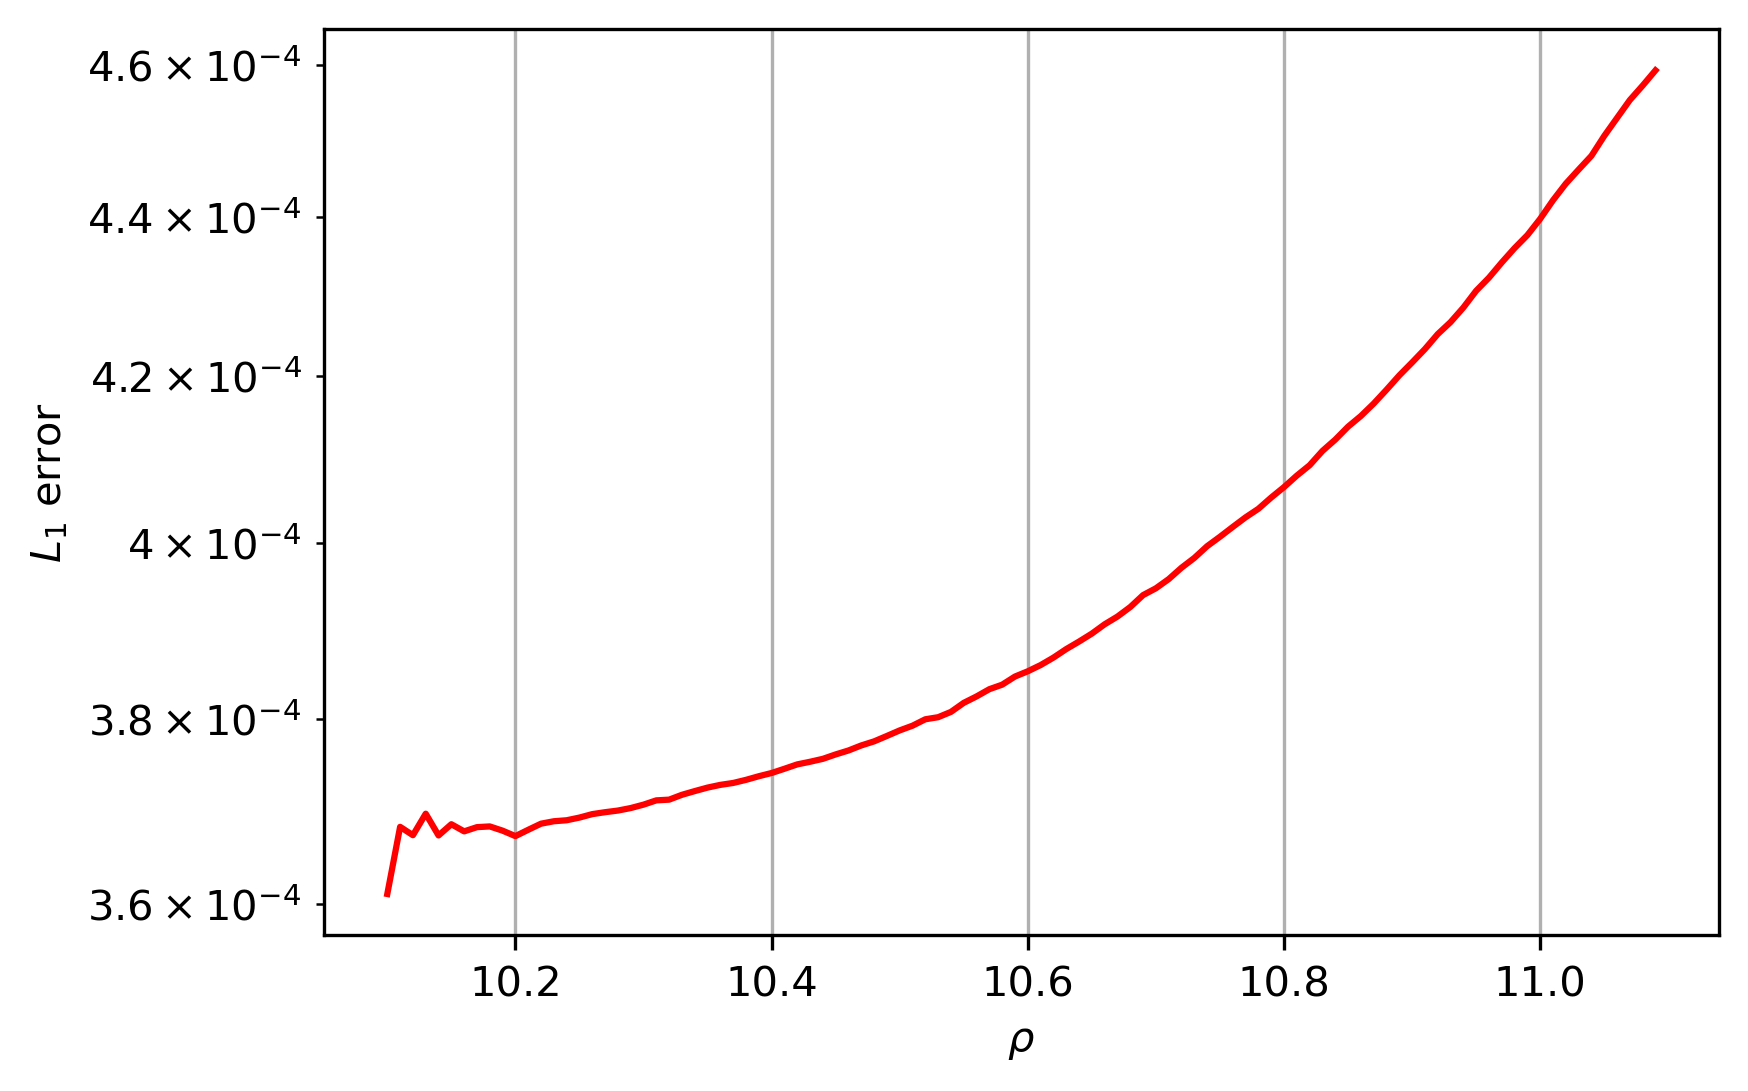

In [119]:
plt.plot(sub_df_rho["rho max"], sub_df_rho["L1"], color='red', label='rho')
# plt.legend()
plt.xlabel(r"$\rho$")
plt.ylabel(r"$L_1$ error")
plt.yscale('log')
plt.grid()
plt.savefig("error_analysis_v1_rho.pdf", bbox_inches='tight')
plt.show()

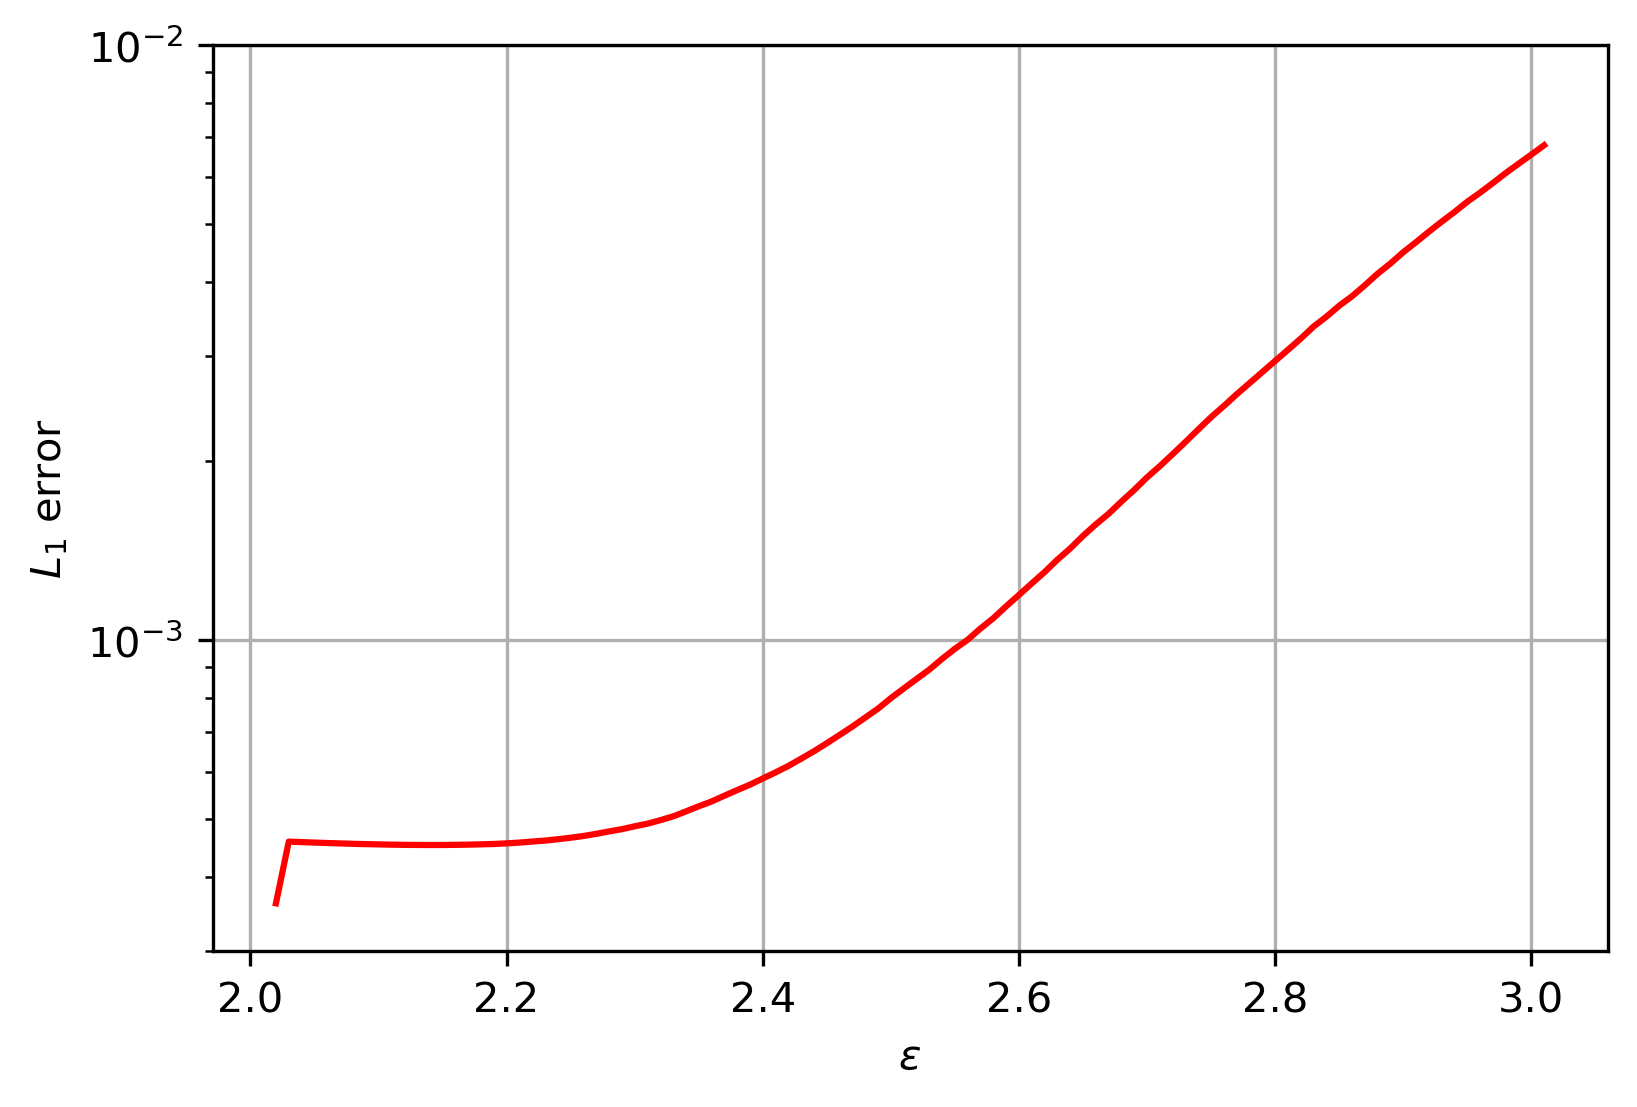

In [130]:
plt.plot(sub_df_eps["eps max"], sub_df_eps["L1"], color='red', label='rho')
# plt.legend()
plt.xlabel(r"$\epsilon$")
plt.ylabel(r"$L_1$ error")
plt.yscale('log')
plt.ylim(3*10**(-4), 10**(-2))
plt.grid()
plt.savefig("error_analysis_v1_eps.pdf", bbox_inches='tight')
plt.show()

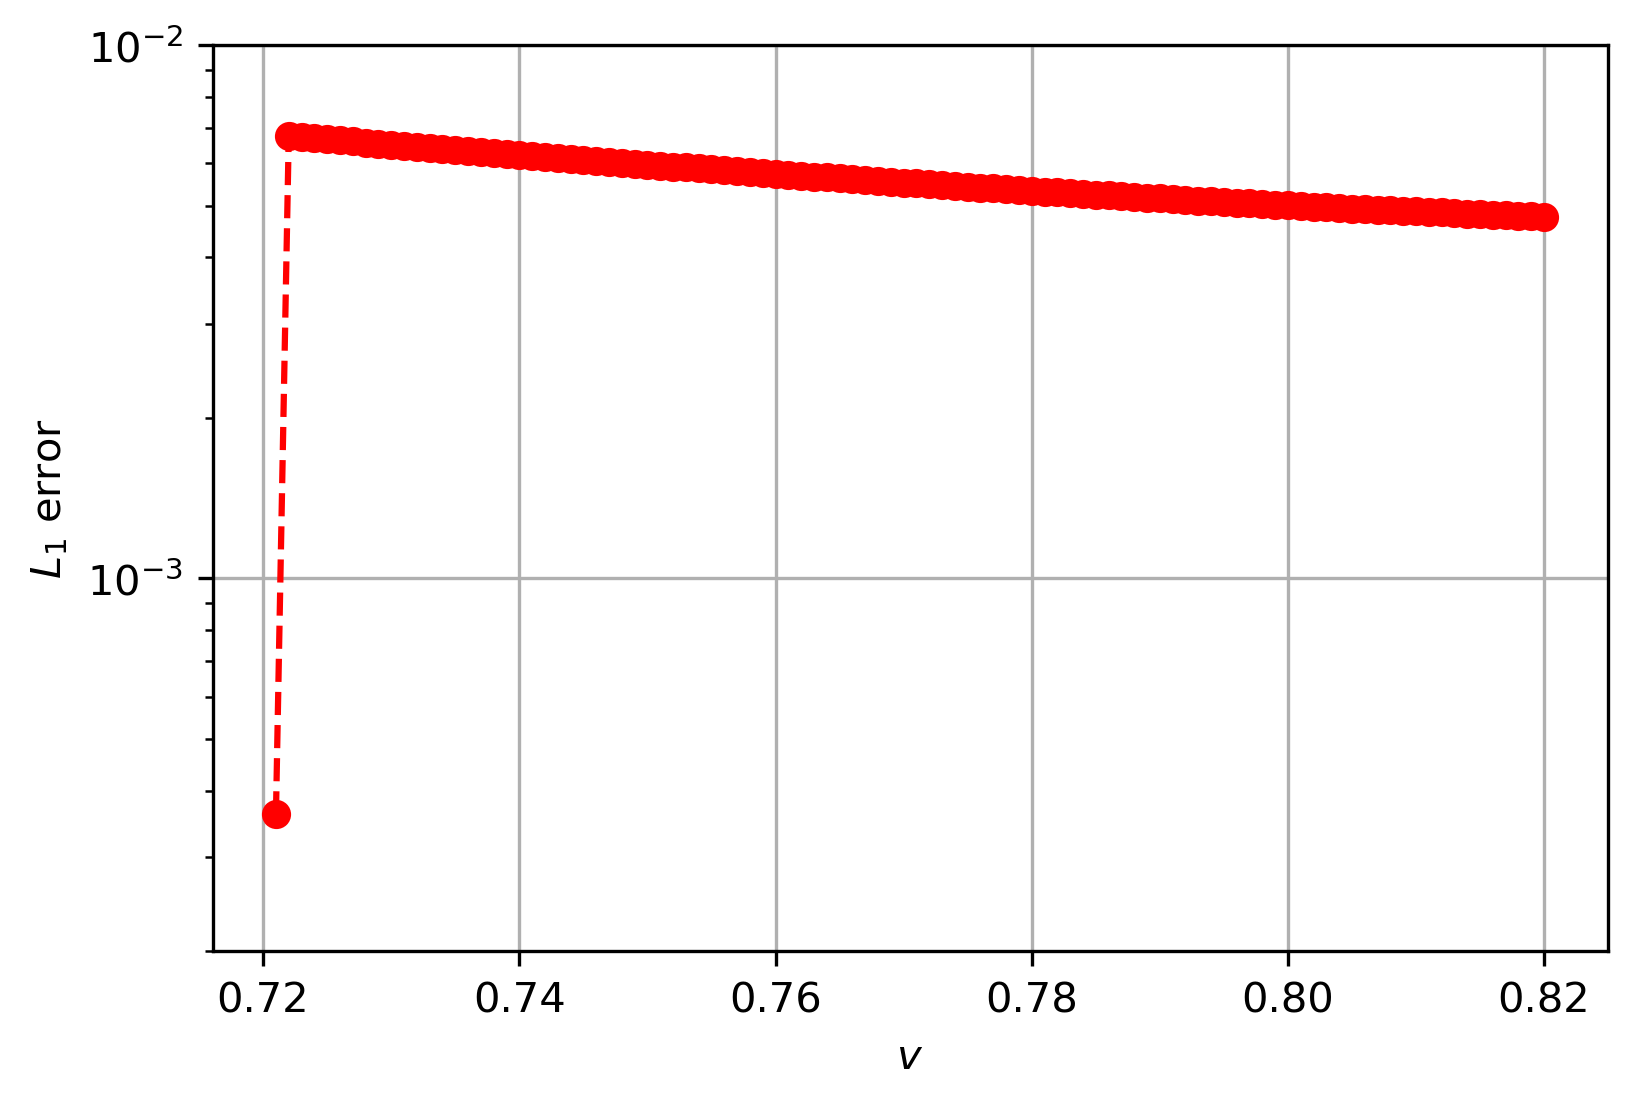

In [129]:
plt.plot(sub_df_v["v max"], sub_df_v["L1"], '--o', color='red', label='rho')
# plt.legend()
plt.xlabel(r"$v$")
plt.ylabel(r"$L_1$ error")
plt.yscale('log')
plt.ylim(2*10**(-4), 10**(-2))
plt.grid()
plt.savefig("error_analysis_v1_v.pdf", bbox_inches='tight')
plt.show()

Save this data to process later on:

In [107]:
# df.to_csv("Data/errors_analysis_v2.csv")

## When all parameters can go outside of their ranges

In [136]:
# We are going to save the performance according to the ranges specified:
# this dict is filled with the errors we found above
errors_dict = {
    "rho max": [rho_max],
    "eps max":[eps_max],
    "v max":[v_max],
    "L1":[delta_p_L1],
    "Linfty":[delta_p_Linfty]}

# Get the parameters we are going to test

# This is how we are going to increment the upper bound each run
delta_rho = 0.02
delta_eps = 0.02
delta_v     = 0.002

number_of_runs = 10

# Construct the parameters
rho_list = [rho_max + i*delta_rho for i in range(1, number_of_runs)]
eps_list = [eps_max + i*delta_eps for i in range(1, number_of_runs)]
v_list      = [v_max     + i*delta_v for i in range(1, number_of_runs)]

In [138]:
number_of_datapoints = 10000

p = []
phat = []

with torch.no_grad():
    # Iterate over all parameter bounds
    for rho_bound in rho_list:
        for eps_bound in eps_list:
            for v_bound in v_list:
                    # Save current values:
                    errors_dict["rho max"].append(rho_bound)
                    errors_dict["eps max"].append(eps_bound)
                    errors_dict["v max"].append(v_bound)

                    # Now get 10 000 new cases and predictions
                    for i in range(number_of_datapoints):

                        # Sample randomly from the new range
                        rho = random.uniform(rho_min, rho_bound)
                        eps = random.uniform(eps_min, eps_bound)
                        v     = random.uniform(v_min,           v_bound)

                        # Get true value
                        p.append(eos(rho, eps))

                        # Get the prediction

                        # Compute features (D, S, tau)
                        Dvalue    = D(rho, eps, v)
                        Svalue     = S(rho, eps, v)
                        tauvalue = tau(rho, eps, v)

                        # Get prediction
                        prediction = model(torch.tensor([Dvalue, Svalue, tauvalue]))
                        phat.append(prediction[0].item())

                    # All values computed, store the errors we found
                    L1 = L1_norm(np.array(p), np.array(phat))
                    errors_dict["L1"].append(L1)
                    Linfty= Linfty_norm(np.array(p), np.array(phat))
                    errors_dict["Linfty"].append(Linfty)

In [139]:
df = pd.DataFrame(errors_dict)
df

rho max  eps max  v max        L1    Linfty
0      10.10     2.02  0.721  0.000361  0.008647
1      10.12     2.04  0.723  0.000368  0.009280
2      10.12     2.04  0.725  0.000369  0.009725
3      10.12     2.04  0.727  0.000371  0.009725
4      10.12     2.04  0.729  0.000373  0.009725
..       ...      ...    ...       ...       ...
725    10.28     2.20  0.731  0.000463  0.135447
726    10.28     2.20  0.733  0.000463  0.135447
727    10.28     2.20  0.735  0.000463  0.135447
728    10.28     2.20  0.737  0.000464  0.135447
729    10.28     2.20  0.739  0.000464  0.135447

[730 rows x 5 columns]

In [150]:
sub_df_rho_eps = df.loc[(df["v max"] == v_max) |( df["v max"] == v_max+delta_v)]
sub_df_rho_v = df.loc[(df["eps max"] == eps_max) |( df["eps max"] == eps_max+delta_eps)]
sub_df_eps_v = df.loc[(df["rho max"] == rho_max) |( df["rho max"] == rho_max+delta_rho)]

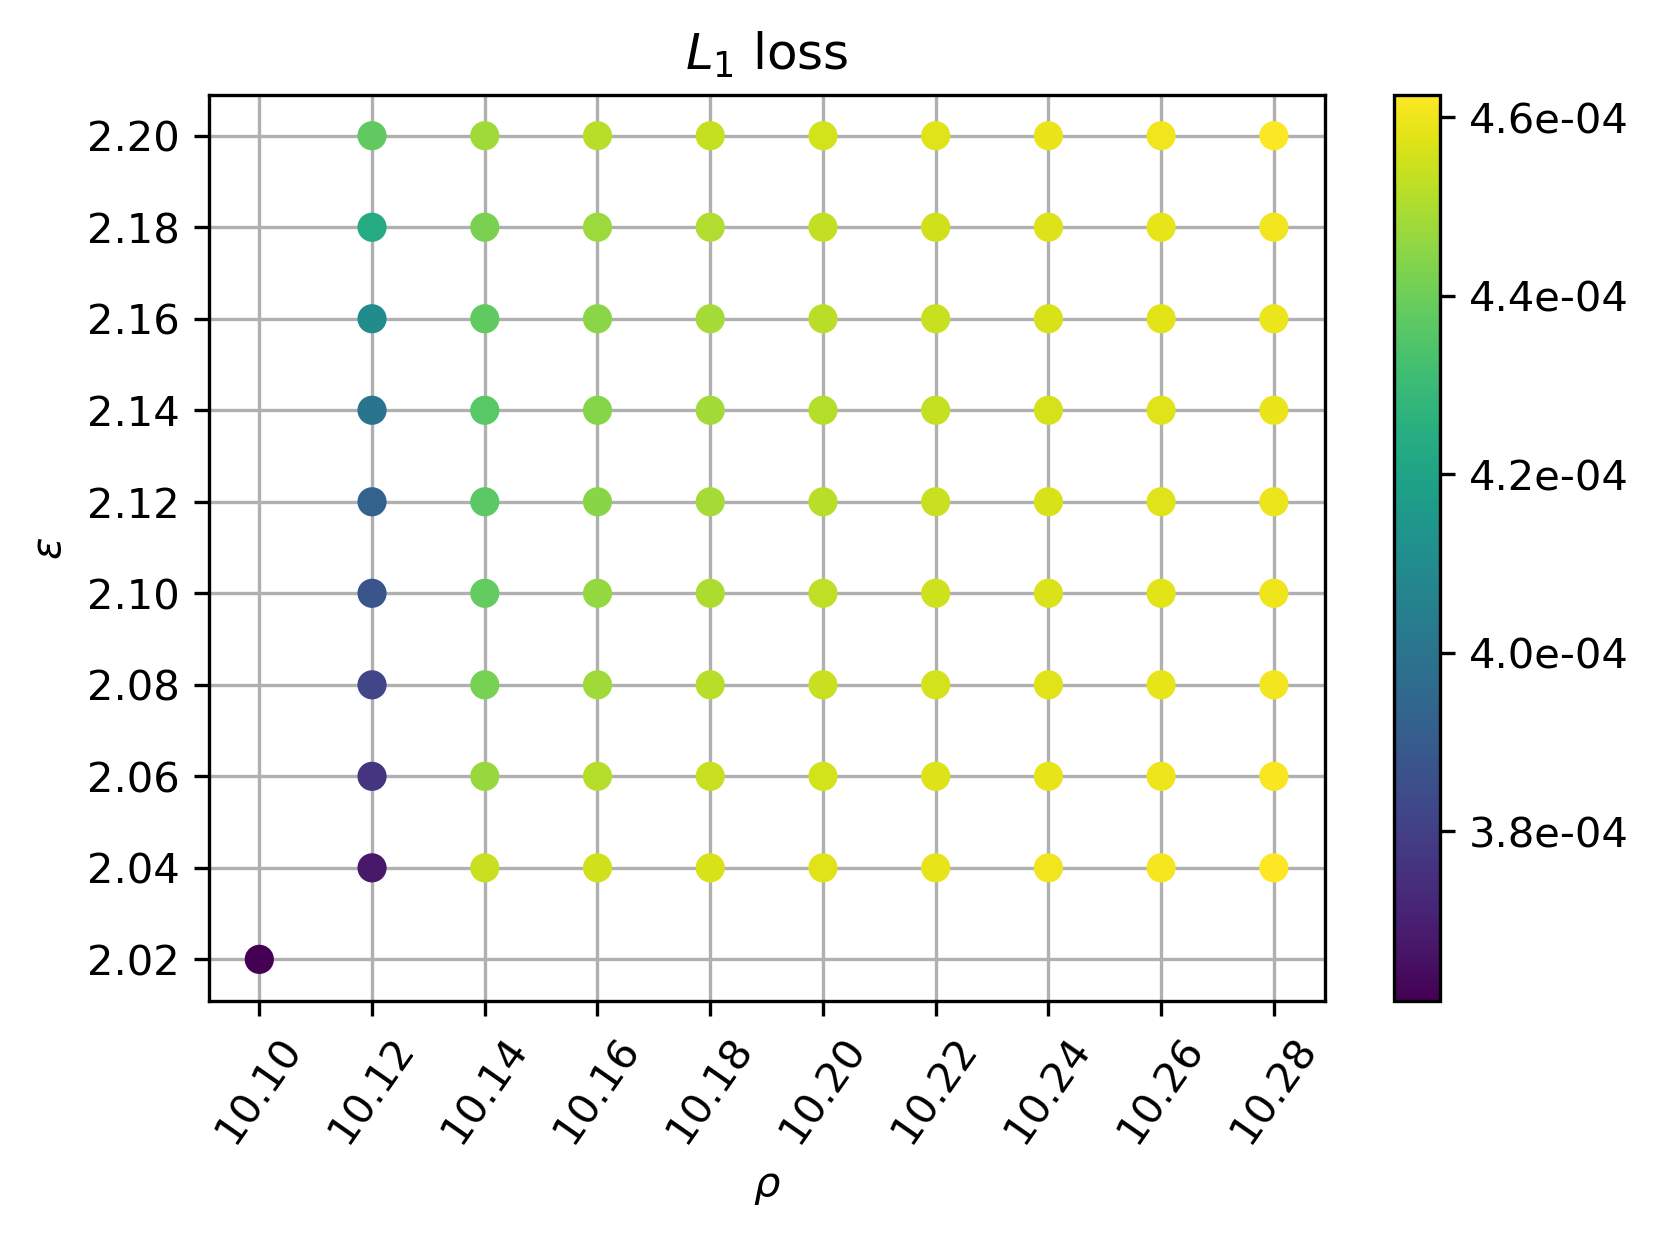

In [178]:
plt.scatter(sub_df_rho_eps["rho max"], sub_df_rho_eps["eps max"], c=sub_df_rho_eps["L1"], zorder=5)
plt.colorbar(format='%0.1e')
plt.xlabel(r"$\rho$")
plt.ylabel(r"$\varepsilon$")
plt.xticks(list(set(sub_df_rho_eps["rho max"])), rotation=55)
plt.yticks(list(set(sub_df_rho_eps["eps max"])))
plt.grid()
plt.title(r"$L_1$ loss")
plt.savefig("error_analysis_rho_eps.pdf", bbox_inches='tight')
plt.show()

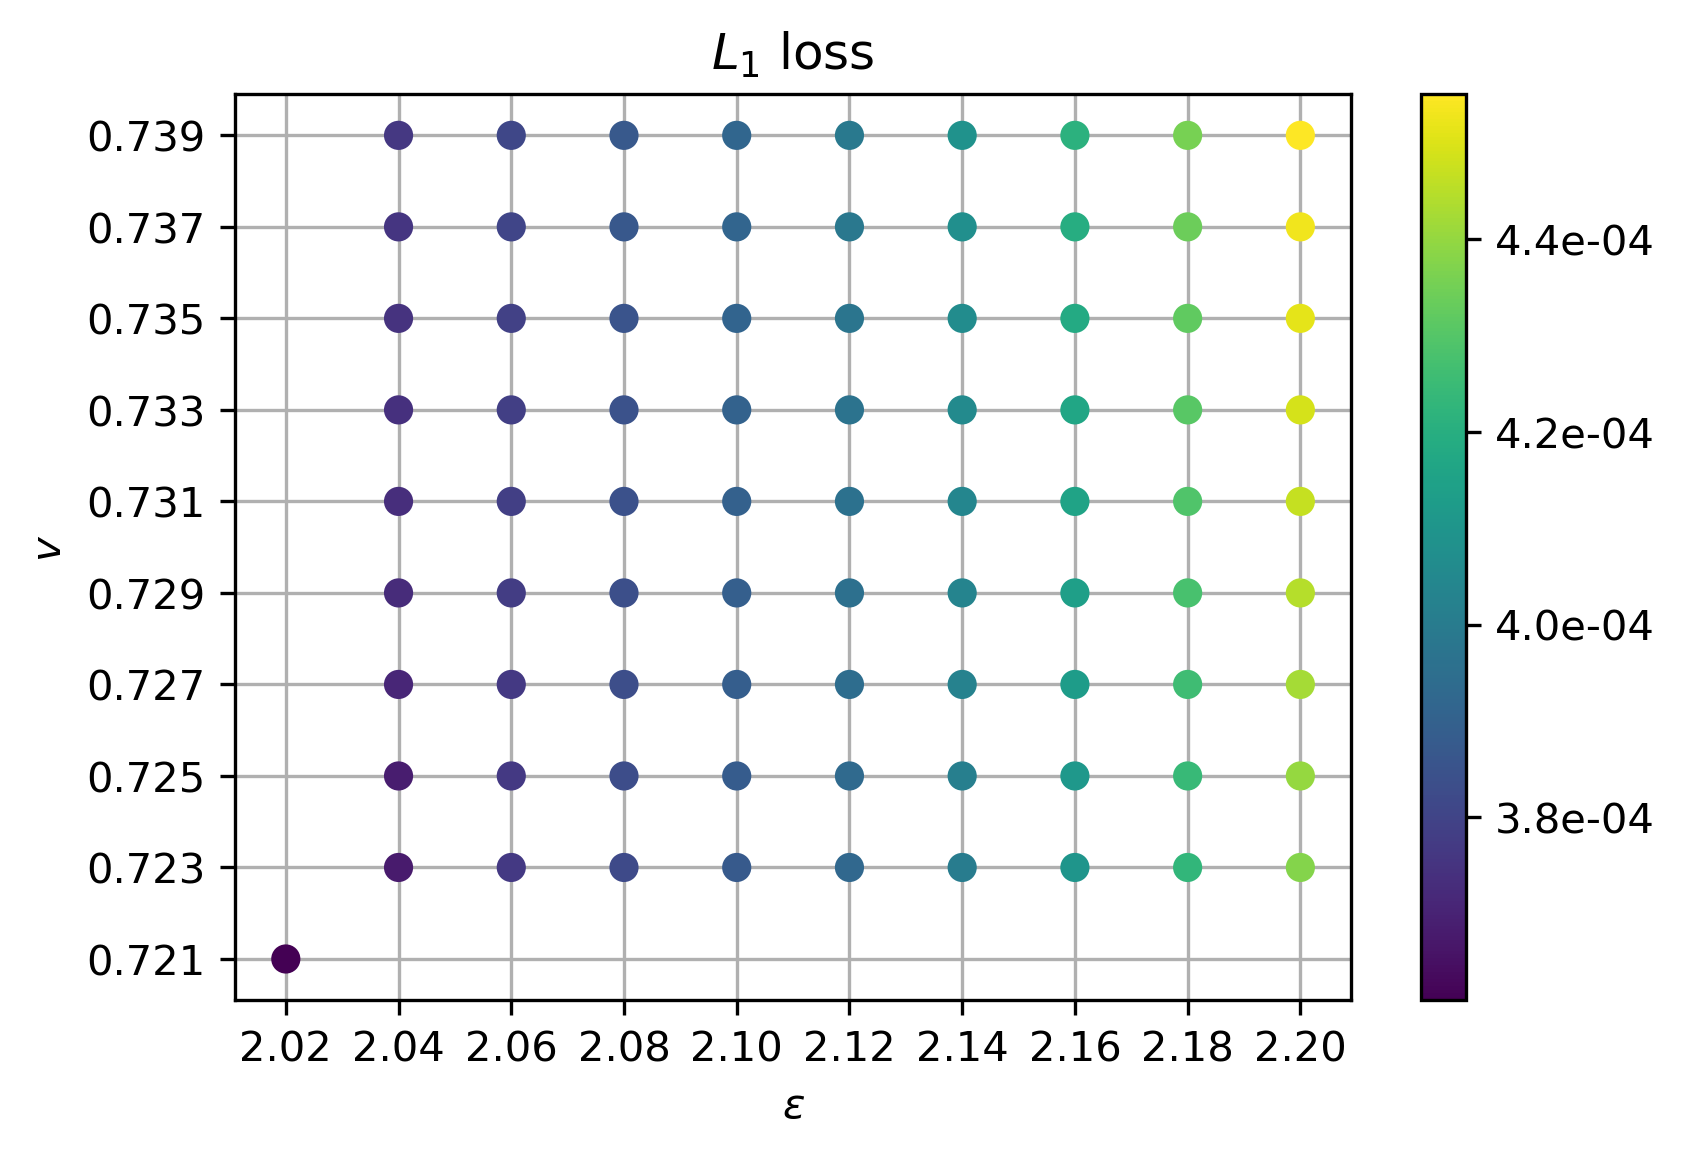

In [180]:
plt.scatter(sub_df_eps_v["eps max"], sub_df_eps_v["v max"], c=sub_df_eps_v["L1"], zorder=5)
plt.colorbar(format='%0.1e')
plt.xticks(list(set(sub_df_eps_v["eps max"])))
plt.yticks(list(set(sub_df_eps_v["v max"])))
plt.grid()
plt.xlabel(r"$\varepsilon$")
plt.ylabel(r"$v$")
plt.title(r"$L_1$ loss")
plt.savefig("error_analysis_eps_v.pdf", bbox_inches='tight')
plt.show()

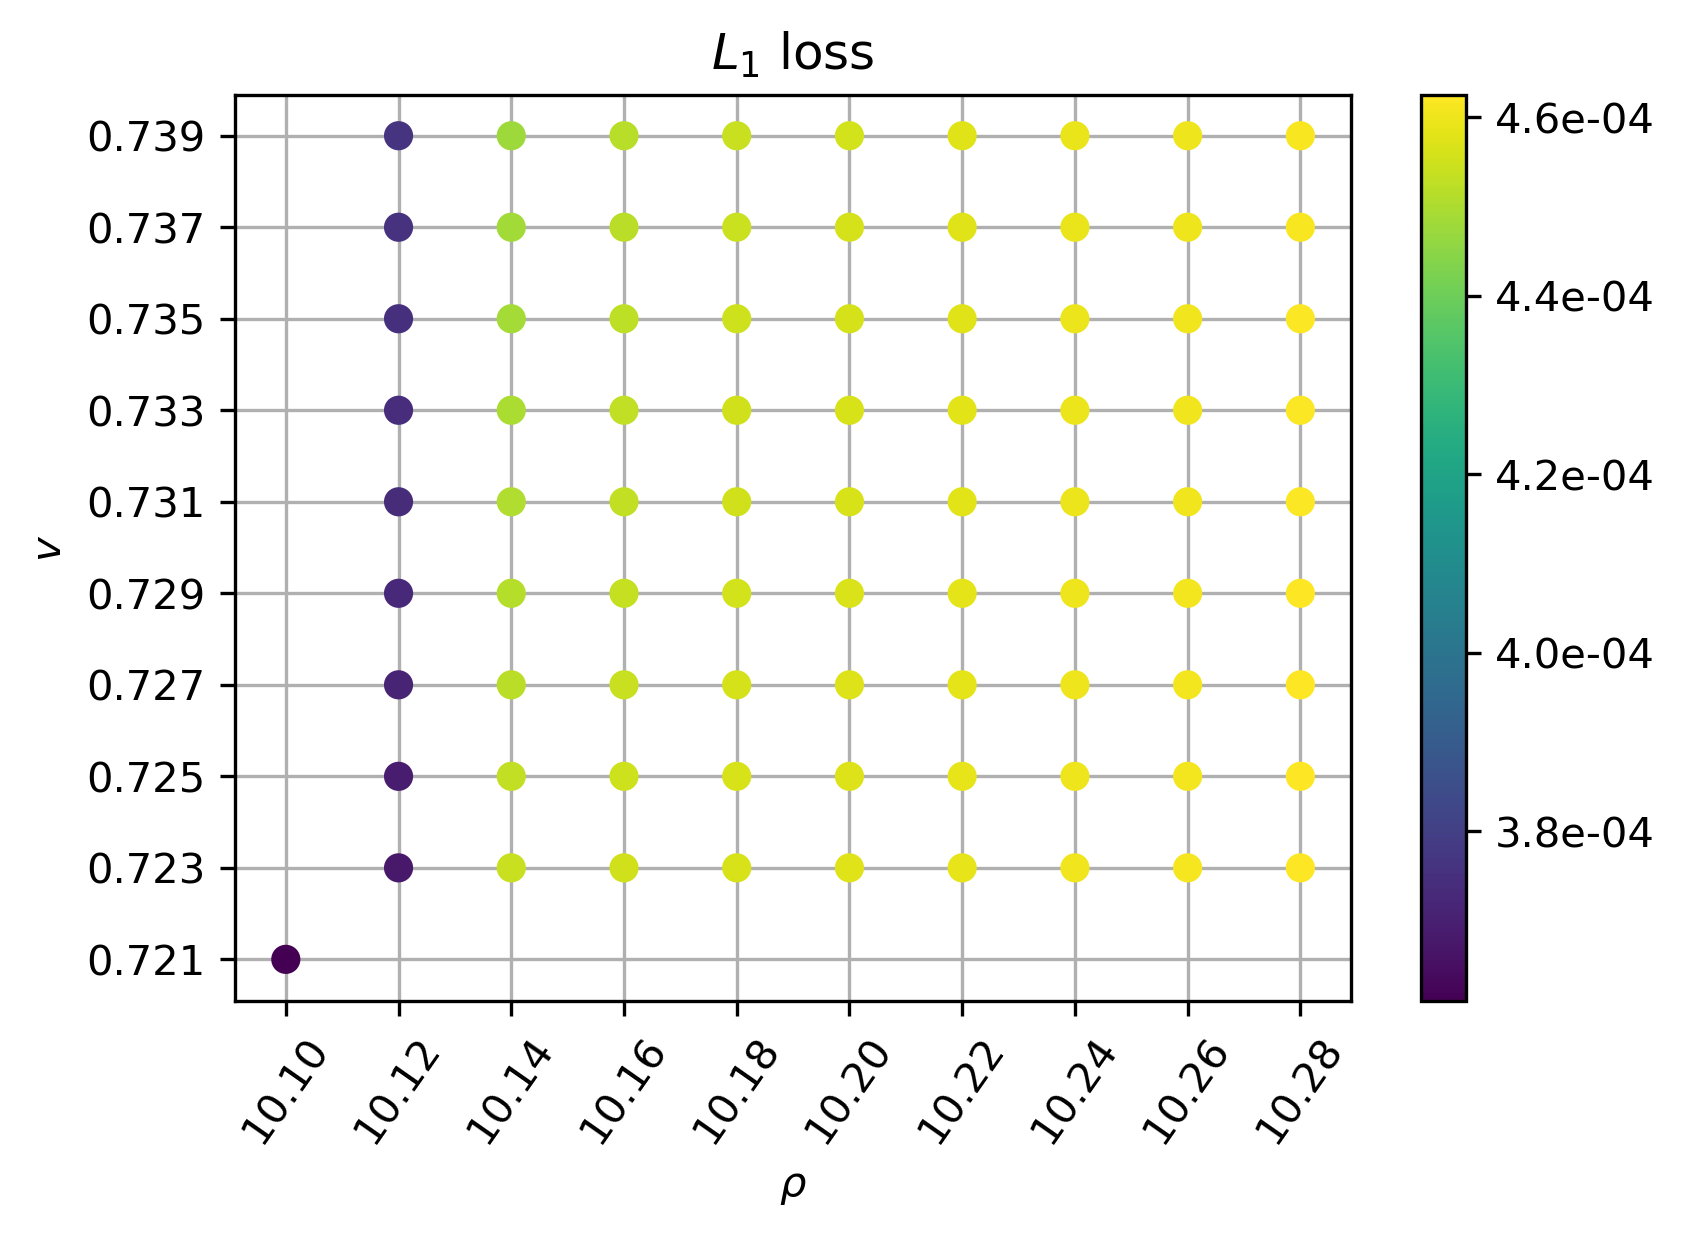

In [184]:
plt.scatter(sub_df_rho_v["rho max"], sub_df_rho_v["v max"], c=sub_df_rho_v["L1"], zorder=5)
plt.colorbar(format='%0.1e')
plt.xlabel(r"$\rho$")
plt.xticks(list(set(sub_df_rho_v["rho max"])), rotation=55)
plt.yticks(list(set(sub_df_rho_v["v max"])))
plt.grid()
plt.ylabel(r"$v$")
plt.title(r"$L_1$ loss")
plt.savefig("error_analysis_rho_v.pdf", bbox_inches='tight')
plt.show()

In [ ]:
# plt.pcolormesh(X, Y, Z, cmap=plt.cm.get_cmap('Blues'))

Save this data to process later on:

In [140]:
# df.to_csv("Data/errors_analysis_v2.csv")

# Get parameters of network out:

In [47]:
with torch.no_grad():
    for param in NNC2P.parameters():
        print(param)

Parameter containing:
tensor([[-0.3637,  0.4540, -0.4355],
        [ 0.0066,  0.6949,  0.4879],
        [ 0.1112, -0.0925,  0.1091],
        ...,
        [ 0.5306, -0.4535, -0.3026],
        [-0.4308, -0.1415,  0.2810],
        [ 0.6349, -0.2947,  0.0561]], requires_grad=True)
Parameter containing:
tensor([ 0.5675,  0.2904, -0.7667, -0.3078, -0.1945,  0.0523,  0.0514, -0.4138,
         0.2312, -0.5222,  0.2495, -0.3197, -0.4844, -0.5024, -0.3668, -0.2699,
         0.7860,  0.7489,  0.1024,  0.8798,  0.1536, -0.4353, -0.3389, -0.5969,
        -0.4334, -0.7355, -0.4756, -0.4140, -0.1220, -0.1788, -0.7250, -0.0075,
         0.2842,  0.1193,  0.5405, -0.1805, -0.0228, -0.3408, -0.1134, -0.2822,
         0.5498, -0.1406,  0.3311, -0.5858,  0.0567, -0.2661,  0.3879,  0.8417,
        -0.2426,  0.5311,  0.0035,  0.1361, -0.3355,  0.2191, -0.3657,  0.0739,
        -0.7668, -0.7611, -0.4528,  0.7155,  0.4711,  0.1546, -0.7966, -0.6006,
         0.5338, -0.4438, -0.5507,  0.2647, -0.5531, -0.1843